# Задача 2 "Спрос на бронирование отелей"

https://www.kaggle.com/competitions/hotel-booking-demand-3/overview

Данные содержат сведения о спросе на отели.Датасет содержит 119 390 наблюдений. Каждое наблюдение представляет собой бронирование отеля. Набор данных учитывает бронирования, которые должны прибыть в период с 1 июля 2015 года по 31 августа 2017 года, включая фактически поступившие и отмененные бронирования.

Данные содержат сведения о **70 146** отелях.
- Тренировочный набор - **44 634 строк**.
- Тестовый набор - **25 512 строк**.

## Считывание данных

In [1]:
# иморитирование всех необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

In [3]:
# Считываем тренировочные данные
train = pd.read_csv("files//train_final.csv")

print(f"Train dataset shape: {train.shape}")

Train dataset shape: (44638, 29)


In [4]:
# Считываем тестовые данные
test = pd.read_csv("files//test_final.csv")

print(f"Test dataset shape: {test.shape}")

Test dataset shape: (23525, 28)


In [5]:
# Посмотрим как выглядят данные
train.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0          3               2016           February   
1    City Hotel            1         50               2016           November   
2    City Hotel            0         14               2015          September   
3    City Hotel            0         18               2015           December   
4    City Hotel            1        263               2016          September   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         7                         12   
1                        47                         18   
2                        37                          7   
3                        50                          6   
4                        40                         29   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     2       2  ...   
1                        1                     2       2  ...   
2                        1                     5       2  ...   
3                        2                     0       2  ...   
4                        2                     4       2  ...   

   reserved_room_type  assigned_room_type booking_changes deposit_type  \
0                   E                   F               0   No Deposit   
1                   A                   A               0   No Deposit   
2                   F                   F               0   No Deposit   
3                   A                   A               0   No Deposit   
4                   A                   A               0   No Deposit   

  days_in_waiting_list customer_type    adr  required_car_parking_spaces  \
0                    0     Transient   81.0                            1   
1                    0     Transient   93.6                            0   
2                    0      Contract  166.0                            0   
3                    0     Transient  107.0                            0   
4                    0     Transient  100.3                            0   

   total_of_special_requests reservation_status_date  
0                          0              2016-02-14  
1                          2              2016-10-09  
2                          3              2015-09-13  
3                          0              2015-12-08  
4                          0              2016-01-18  

[5 rows x 29 columns]

## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [6]:
print("Number of missing values in train dataset:")
print(train.isna().sum())
print("Number of missing values in test dataset:")
print(test.isna().sum())

Number of missing values in train dataset:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44638 entries, 0 to 44637
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           44638 non-null  object 
 1   is_canceled                     44638 non-null  int64  
 2   lead_time                       44638 non-null  int64  
 3   arrival_date_year               44638 non-null  int64  
 4   arrival_date_month              44638 non-null  object 
 5   arrival_date_week_number        44638 non-null  int64  
 6   arrival_date_day_of_month       44638 non-null  int64  
 7   stays_in_weekend_nights         44638 non-null  int64  
 8   stays_in_week_nights            44638 non-null  int64  
 9   adults                          44638 non-null  int64  
 10  children                        44638 non-null  float64
 11  babies                          44638 non-null  int64  
 12  meal                            

**Проверим баланс классов.**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

In [8]:
train['is_canceled'].value_counts()

0    31354
1    13284
Name: is_canceled, dtype: int64

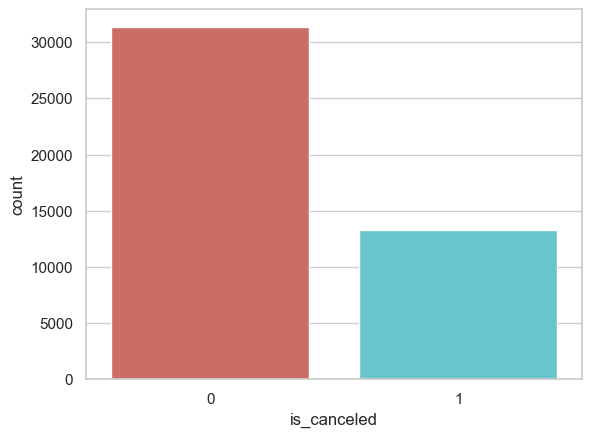

In [10]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
y_data = pd.DataFrame(train['is_canceled'])
sns.countplot(x='is_canceled', data=y_data, palette='hls')
plt.show()

## Предобработка данных

Исходя из анализа данных, можно сделать выводы:
- в данных пропусков нет
- в данных имеются категориальные признаки
- в задаче решается задача бинарной классификации

### Кодирование признаков

**Категориальные признаки называют по-разному: факторными, номинальными.**

Их значения определяют факт принадлежности к какой-то категории. Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа.

**Категориальные** признаки называют по-разному: **факторными**, **номинальными**. Их значения определяют факт принадлежности к какой-то категории.

Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа.

Существуют разные способы кодирования категориальных признаков:
1. Простейший кодировщий `sklearn.preprocessing.LabelEncoder`, который каждой категории сопоставляет некоторое целое число (собственно, номер категории).

Например, существует категориальная переменная:

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |    Вакцинирован    |
2  |  Не вакцинирован   |
3  |     Мед отвод      |
4  |     Мед отвод      |
5  |  Не вакцинирован   |
6  |    Вакцинирован    |

```

После применения кодирования с помощью LabelEncoder получаем следущее (собственно он закодировал наши категориальные переменные: Вакцинирован = 0, Не вакцинирован = 1, Мед отвод = 2):

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |         0          |
2  |         1          |
3  |         2          |
4  |         2          |
5  |         1          |
6  |         0          |

```

2. Метод библиотеки Pandas:

`pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)[source]`

Например, существует категориальная переменная:

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |    Вакцинирован    |
2  |  Не вакцинирован   |
3  |     Мед отвод      |
4  |     Мед отвод      |
5  |  Не вакцинирован   |
6  |    Вакцинирован    |

```

Метод принимает категориальную переменную в качестве аргумента. Далее создает новую переменную для каждой категории, так что каждая фиктивная переменная содержит данные 1 или 0. 1 - указывает на наличие определенной категории и 0 - указывает на отсутствие этой категории.

```markdown
   | Статус вакцинации | Вакцинирован | Не вакцинирован | Мед отвод |
---|-------------------|--------------|-----------------|-----------|
1  |   Вакцинирован    |      1       |        0        |     0     |
2  | Не вакцинирован   |      0       |        1        |     0     |
3  |    Мед отвод      |      0       |        0        |     1     |
4  |    Мед отвод      |      0       |        0        |     1     |
5  | Не вакцинирован   |      0       |        1        |     0     |
6  |   Вакцинирован    |      1       |        0        |     0     |

```

3. Кодировщик библиотеки Sklearn `from sklearn.preprocessing import OneHotEncoder`.

По принципу работы действует точно также как get_dummies().

Основное отличие - это кодировщик, т.е. это некоторая модель которая обучилась на данных, запомнила словарь и т.д., дальше может быть с этими параметры применяться к другому набору данных, к новым данным например.

Get_dummies() - это просто метод класса, который по сути вы одноразово используете.

In [11]:
# Выбрем признаки, которые являются категориальными (строковыми)
train.loc[:, train.dtypes == object]

hotel arrival_date_month meal country market_segment  \
0      Resort Hotel           February   BB     PRT         Direct   
1        City Hotel           November   BB     BEL      Online TA   
2        City Hotel          September   BB     ITA      Online TA   
3        City Hotel           December   BB     ESP      Online TA   
4        City Hotel          September   BB     DEU      Online TA   
...             ...                ...  ...     ...            ...   
44633    City Hotel               June   BB     JPN      Online TA   
44634  Resort Hotel          September   BB     GBR      Online TA   
44635    City Hotel              April   SC     PRT      Online TA   
44636    City Hotel          September   HB     NOR  Offline TA/TO   
44637    City Hotel           November   BB     PRT      Corporate   

      distribution_channel reserved_room_type assigned_room_type deposit_type  \
0                   Direct                  E                  F   No Deposit   
1                    TA/TO                  A                  A   No Deposit   
2                    TA/TO                  F                  F   No Deposit   
3                    TA/TO                  A                  A   No Deposit   
4                    TA/TO                  A                  A   No Deposit   
...                    ...                ...                ...          ...   
44633                TA/TO                  D                  D   No Deposit   
44634                TA/TO                  E                  F   No Deposit   
44635                TA/TO                  A                  A   No Deposit   
44636                TA/TO                  A                  A   No Deposit   
44637            Corporate                  A                  A   No Deposit   

         customer_type reservation_status_date  
0            Transient              2016-02-14  
1            Transient              2016-10-09  
2             Contract              2015-09-13  
3            Transient              2015-12-08  
4            Transient              2016-01-18  
...                ...                     ...  
44633        Transient              2017-06-28  
44634        Transient              2015-10-03  
44635        Transient              2017-02-09  
44636  Transient-Party              2016-09-12  
44637  Transient-Party              2015-11-18  

[44638 rows x 11 columns]

In [12]:
train = train.drop(columns=['reservation_status_date', 'country', 'assigned_room_type', 'reserved_room_type'])
test = test.drop(columns=['reservation_status_date', 'country', 'assigned_room_type', 'reserved_room_type'])

In [13]:
cat_features = train.loc[:, train.dtypes == object].columns
cat_features

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment',
       'distribution_channel', 'deposit_type', 'customer_type'],
      dtype='object')

In [14]:
train['hotel'].value_counts()

City Hotel      29335
Resort Hotel    15303
Name: hotel, dtype: int64

In [15]:
train['market_segment'].value_counts()

Online TA        21325
Offline TA/TO     9085
Groups            6868
Direct            4922
Corporate         2046
Complementary      308
Aviation            84
Name: market_segment, dtype: int64

In [16]:
train['deposit_type'].value_counts()

No Deposit    40235
Non Refund     4339
Refundable       64
Name: deposit_type, dtype: int64

In [17]:
# Закодируем часть категориальных признаков с помощью LabelEncoder()
# а часть с помощью GetDummies()

from sklearn import preprocessing

# 1. Создадим модель кодировщика
label_encoder = preprocessing.LabelEncoder()

# 2. Обучение кодировщика: по сути тут создает словарь уникальных слов из переданного массива,
# соотносит для каждого слова число
label_encoder.fit(train['arrival_date_month'])

# на этом этапе по сути применяет полученный словарь в переданным данных (в данном случае мы передали столбец число)
train['arrival_date_month'] = label_encoder.transform(train['arrival_date_month'])
# сразу используя этот кодировщик трансформируем данные теста
test['arrival_date_month'] = label_encoder.transform(test['arrival_date_month'])

train.head()

hotel  is_canceled  lead_time  arrival_date_year  \
0  Resort Hotel            0          3               2016   
1    City Hotel            1         50               2016   
2    City Hotel            0         14               2015   
3    City Hotel            0         18               2015   
4    City Hotel            1        263               2016   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   3                         7                         12   
1                   9                        47                         18   
2                  11                        37                          7   
3                   2                        50                          6   
4                  11                        40                         29   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     2       2  ...   
1                        1                     2       2  ...   
2                        1                     5       2  ...   
3                        2                     0       2  ...   
4                        2                     4       2  ...   

   is_repeated_guest  previous_cancellations previous_bookings_not_canceled  \
0                  0                       0                              0   
1                  0                       0                              0   
2                  0                       0                              0   
3                  0                       0                              0   
4                  0                       0                              0   

  booking_changes deposit_type  days_in_waiting_list  customer_type    adr  \
0               0   No Deposit                     0      Transient   81.0   
1               0   No Deposit                     0      Transient   93.6   
2               0   No Deposit                     0       Contract  166.0   
3               0   No Deposit                     0      Transient  107.0   
4               0   No Deposit                     0      Transient  100.3   

   required_car_parking_spaces total_of_special_requests  
0                            1                         0  
1                            0                         2  
2                            0                         3  
3                            0                         0  
4                            0                         0  

[5 rows x 25 columns]

In [18]:
label_encoder.classes_

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [19]:
test.loc[:, test.dtypes == object]

hotel meal market_segment distribution_channel deposit_type  \
0        City Hotel   SC      Online TA                TA/TO   No Deposit   
1        City Hotel   SC      Online TA                TA/TO   No Deposit   
2        City Hotel   BB      Online TA                TA/TO   No Deposit   
3        City Hotel   BB         Direct               Direct   No Deposit   
4      Resort Hotel   BB         Groups            Corporate   No Deposit   
...             ...  ...            ...                  ...          ...   
23520    City Hotel   BB  Offline TA/TO                TA/TO   No Deposit   
23521    City Hotel   BB      Corporate            Corporate   No Deposit   
23522    City Hotel   BB      Corporate            Corporate   No Deposit   
23523  Resort Hotel   BB         Groups                TA/TO   No Deposit   
23524  Resort Hotel   HB      Online TA                TA/TO   No Deposit   

         customer_type  
0            Transient  
1            Transient  
2            Transient  
3            Transient  
4      Transient-Party  
...                ...  
23520        Transient  
23521        Transient  
23522        Transient  
23523  Transient-Party  
23524        Transient  

[23525 rows x 6 columns]

In [20]:
test.loc[:, test.dtypes == object].columns

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'deposit_type', 'customer_type'],
      dtype='object')

In [21]:
from sklearn import preprocessing

categ = ['market_segment', 'customer_type', 'meal', 'distribution_channel']

for col in categ:
    le = preprocessing.LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

train.head()

hotel  is_canceled  lead_time  arrival_date_year  \
0  Resort Hotel            0          3               2016   
1    City Hotel            1         50               2016   
2    City Hotel            0         14               2015   
3    City Hotel            0         18               2015   
4    City Hotel            1        263               2016   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   3                         7                         12   
1                   9                        47                         18   
2                  11                        37                          7   
3                   2                        50                          6   
4                  11                        40                         29   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     2       2  ...   
1                        1                     2       2  ...   
2                        1                     5       2  ...   
3                        2                     0       2  ...   
4                        2                     4       2  ...   

   is_repeated_guest  previous_cancellations  previous_bookings_not_canceled  \
0                  0                       0                               0   
1                  0                       0                               0   
2                  0                       0                               0   
3                  0                       0                               0   
4                  0                       0                               0   

   booking_changes  deposit_type  days_in_waiting_list  customer_type    adr  \
0                0    No Deposit                     0              2   81.0   
1                0    No Deposit                     0              2   93.6   
2                0    No Deposit                     0              0  166.0   
3                0    No Deposit                     0              2  107.0   
4                0    No Deposit                     0              2  100.3   

   required_car_parking_spaces total_of_special_requests  
0                            1                         0  
1                            0                         2  
2                            0                         3  
3                            0                         0  
4                            0                         0  

[5 rows x 25 columns]

In [22]:
# Попробуем другой вариант кодировщика
train = pd.get_dummies(train, columns=['hotel', 'market_segment', 'deposit_type'])

train.head()

is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0            0          3               2016                   3   
1            1         50               2016                   9   
2            0         14               2015                  11   
3            0         18               2015                   2   
4            1        263               2016                  11   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         7                         12   
1                        47                         18   
2                        37                          7   
3                        50                          6   
4                        40                         29   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
0                        0                     2       2       0.0  ...   
1                        1                     2       2       0.0  ...   
2                        1                     5       2       2.0  ...   
3                        2                     0       2       0.0  ...   
4                        2                     4       2       0.0  ...   

   market_segment_0  market_segment_1  market_segment_2  market_segment_3  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   market_segment_4  market_segment_5  market_segment_6  \
0                 0                 0                 0   
1                 0                 0                 1   
2                 0                 0                 1   
3                 0                 0                 1   
4                 0                 0                 1   

   deposit_type_No Deposit  deposit_type_Non Refund  deposit_type_Refundable  
0                        1                        0                        0  
1                        1                        0                        0  
2                        1                        0                        0  
3                        1                        0                        0  
4                        1                        0                        0  

[5 rows x 34 columns]

In [ ]:
train.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                                int64
distribution_channel                int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
days_in_waiting_list                int64
customer_type                       int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
hotel_City Hotel                    uint8
hotel_Resort Hotel                

In [23]:
# Попробуем другой вариант кодировщика
test = pd.get_dummies(test, columns=['hotel', 'market_segment', 'deposit_type'])

test.dtypes

lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int32
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                                int32
distribution_channel                int32
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
days_in_waiting_list                int64
customer_type                       int32
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
hotel_City Hotel                    uint8
hotel_Resort Hotel                  uint8
market_segment_0                  

## Обучение модели

Теперь наши данные готовы для обучения модели.

In [24]:
# Выделим вектор признаков и вектор ответов
X = train.drop(columns=['is_canceled'])
y = train['is_canceled']

Всего у нас получилось 33 признака.

In [25]:
print(f'X shape: {X.shape}')
print(f'Y shape: {y.shape}')

X shape: (44638, 33)
Y shape: (44638,)


In [26]:
# Создадим модель логистической регрессии
model = LogisticRegression()

# обучение модели
model.fit(X, y)

# предсказание ответов для тестовой выборки
answers_pred = model.predict(X)

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy: {accuracy_score(y, answers_pred)}')
print(f'Precision: {precision_score(y, answers_pred)}')
print(f'Recall: {recall_score(y, answers_pred)}')

Accuracy: 0.8034410143823648
Precision: 0.7865311308767471
Recall: 0.4659741041854863


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


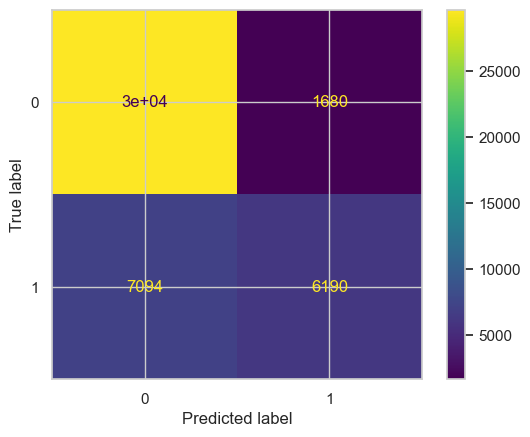

In [28]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(model, X, y)
plt.show()

## Предсказание ответа для тестового набора данных

In [29]:
test.shape

(23525, 33)

In [30]:
y_pred_test = model.predict(test)

In [31]:
y_pred_test

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [33]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['is_canceled'])
y_pred_test = y_pred_test.reset_index()

y_pred_test.to_csv("solution.csv", index=False)

# Самостоятельная работа. Предсказание ответа для тестового набора данных.

In [83]:
import pandas as pd

train = pd.read_csv('files//train_final.csv')
test = pd.read_csv('files//test_final.csv')

train.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0          3               2016           February   
1    City Hotel            1         50               2016           November   
2    City Hotel            0         14               2015          September   
3    City Hotel            0         18               2015           December   
4    City Hotel            1        263               2016          September   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         7                         12   
1                        47                         18   
2                        37                          7   
3                        50                          6   
4                        40                         29   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     2       2  ...   
1                        1                     2       2  ...   
2                        1                     5       2  ...   
3                        2                     0       2  ...   
4                        2                     4       2  ...   

   reserved_room_type  assigned_room_type booking_changes deposit_type  \
0                   E                   F               0   No Deposit   
1                   A                   A               0   No Deposit   
2                   F                   F               0   No Deposit   
3                   A                   A               0   No Deposit   
4                   A                   A               0   No Deposit   

  days_in_waiting_list customer_type    adr  required_car_parking_spaces  \
0                    0     Transient   81.0                            1   
1                    0     Transient   93.6                            0   
2                    0      Contract  166.0                            0   
3                    0     Transient  107.0                            0   
4                    0     Transient  100.3                            0   

   total_of_special_requests reservation_status_date  
0                          0              2016-02-14  
1                          2              2016-10-09  
2                          3              2015-09-13  
3                          0              2015-12-08  
4                          0              2016-01-18  

[5 rows x 29 columns]

In [84]:
train.isna().any().any()

False

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44638 entries, 0 to 44637
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           44638 non-null  object 
 1   is_canceled                     44638 non-null  int64  
 2   lead_time                       44638 non-null  int64  
 3   arrival_date_year               44638 non-null  int64  
 4   arrival_date_month              44638 non-null  object 
 5   arrival_date_week_number        44638 non-null  int64  
 6   arrival_date_day_of_month       44638 non-null  int64  
 7   stays_in_weekend_nights         44638 non-null  int64  
 8   stays_in_week_nights            44638 non-null  int64  
 9   adults                          44638 non-null  int64  
 10  children                        44638 non-null  float64
 11  babies                          44638 non-null  int64  
 12  meal                            

In [87]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_category = train.select_dtypes([object])
test_category = test.select_dtypes([object])

train_encoded = encoder.fit_transform(train_category)
test_encoded = encoder.transform(test_category)

train_encoded_df = pd.DataFrame(train_encoded, columns=train_category.columns)
test_encoded_df = pd.DataFrame(test_encoded, columns=test_category.columns)

train_encoded_full = pd.concat([train.select_dtypes(exclude=object), train_encoded_df], axis=1)
test_encoded_full = pd.concat([test.select_dtypes(exclude=object), test_encoded_df], axis=1)

train_encoded_full.head()

is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
0            0          3               2016                         7   
1            1         50               2016                        47   
2            0         14               2015                        37   
3            0         18               2015                        50   
4            1        263               2016                        40   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                         12                        0                     2   
1                         18                        1                     2   
2                          7                        1                     5   
3                          6                        2                     0   
4                         29                        2                     4   

   adults  children  babies  ...  arrival_date_month  meal  country  \
0       2       0.0       0  ...                 3.0   0.0    121.0   
1       2       0.0       0  ...                 9.0   0.0     12.0   
2       2       2.0       0  ...                11.0   0.0     71.0   
3       2       0.0       0  ...                 2.0   0.0     46.0   
4       2       0.0       0  ...                11.0   0.0     38.0   

   market_segment  distribution_channel  reserved_room_type  \
0             3.0                   1.0                 4.0   
1             6.0                   3.0                 0.0   
2             6.0                   3.0                 5.0   
3             6.0                   3.0                 0.0   
4             6.0                   3.0                 0.0   

   assigned_room_type  deposit_type  customer_type  reservation_status_date  
0                 5.0           0.0            2.0                    315.0  
1                 0.0           0.0            2.0                    553.0  
2                 5.0           0.0            0.0                    161.0  
3                 0.0           0.0            2.0                    247.0  
4                 0.0           0.0            2.0                    288.0  

[5 rows x 29 columns]

In [70]:
#from sklearn.preprocessing import OneHotEncoder
#import pandas as pd

#ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

#train_category = train.select_dtypes([object])
#test_category = test.select_dtypes([object])

#ohe.fit(train_category)

#train_codes = ohe.transform(train_category).toarray()
#test_codes = ohe.transform(test_category).toarray()

#feature_names = ohe.get_feature_names_out(train_category.columns)

#train_ohe = pd.concat([train.select_dtypes(exclude=object), pd.DataFrame(train_codes, columns=feature_names).astype(int)], axis=1)
#test_ohe = pd.concat([test.select_dtypes(exclude=object), pd.DataFrame(test_codes, columns=feature_names).astype(int)], axis=1)

#train_ohe.head()

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 6, 7, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
0            0          3               2016                         7   
1            1         50               2016                        47   
2            0         14               2015                        37   
3            0         18               2015                        50   
4            1        263               2016                        40   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                         12                        0                     2   
1                         18                        1                     2   
2                          7                        1                     5   
3                          6                        2                     0   
4                         29                        2                     4   

   adults  children  babies  ...  reservation_status_date_2017-09-01  \
0       2       0.0       0  ...                                   0   
1       2       0.0       0  ...                                   0   
2       2       2.0       0  ...                                   0   
3       2       0.0       0  ...                                   0   
4       2       0.0       0  ...                                   0   

   reservation_status_date_2017-09-02  reservation_status_date_2017-09-03  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   reservation_status_date_2017-09-04  reservation_status_date_2017-09-05  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   reservation_status_date_2017-09-06  reservation_status_date_2017-09-07  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   reservation_status_date_2017-09-08  reservation_status_date_2017-09-09  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   reservation_status_date_2017-09-10  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0  

[5 rows x 1110 columns]

In [88]:
from sklearn.model_selection import train_test_split

X = train_encoded_full.drop(columns = ['is_canceled'])
y = train_encoded_full['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=43)

X_train.head()

lead_time  arrival_date_year  arrival_date_week_number  \
10712          0               2017                        25   
31825         13               2017                        30   
11102         29               2016                        51   
5235           7               2017                        18   
917           52               2017                         3   

       arrival_date_day_of_month  stays_in_weekend_nights  \
10712                         22                        0   
31825                         24                        1   
11102                         16                        0   
5235                           4                        0   
917                           21                        2   

       stays_in_week_nights  adults  children  babies  is_repeated_guest  ...  \
10712                     2       2       0.0       0                  0  ...   
31825                     0       1       0.0       0                  0  ...   
11102                     2       1       0.0       0                  0  ...   
5235                      2       2       0.0       0                  0  ...   
917                       3       2       1.0       0                  0  ...   

       arrival_date_month  meal  country  market_segment  \
10712                 6.0   0.0     21.0             3.0   
31825                 5.0   0.0    121.0             2.0   
11102                 2.0   0.0     46.0             6.0   
5235                  8.0   0.0    109.0             6.0   
917                   4.0   0.0    121.0             6.0   

       distribution_channel  reserved_room_type  assigned_room_type  \
10712                   1.0                 0.0                 0.0   
31825                   0.0                 0.0                 3.0   
11102                   3.0                 0.0                 3.0   
5235                    3.0                 3.0                 3.0   
917                     3.0                 0.0                 0.0   

       deposit_type  customer_type  reservation_status_date  
10712           0.0            2.0                    811.0  
31825           0.0            2.0                    842.0  
11102           0.0            2.0                    623.0  
5235            0.0            2.0                    762.0  
917             0.0            2.0                    605.0  

[5 rows x 28 columns]

In [89]:
X_train.shape

(33478, 28)

**LogisticRegression**

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'F1-score = {f1_score(y_test, y_pred)}')

Accuracy = 0.7773297491039427
F1-score = 0.5462844622968779


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**kNN**

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_grid = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_grid, param_grid={'n_neighbors' : [2, 3, 5, 7, 10]}, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'n_neighbors': 2}


In [116]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'F1-score = {f1_score(y_test, y_pred)}')

Accuracy = 0.8828853046594982
F1-score = 0.7711434074592891


**RandomForestClassifier**

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'F1-score = {f1_score(y_test, y_pred)}')

Accuracy = 0.9294802867383513
F1-score = 0.8706230478382377


**XGBoost**

In [95]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300, 500], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.1, 0.2, 0.3]}

xgb_grid = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_grid, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}


In [109]:
xgb = XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.2, random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'F1-score = {f1_score(y_test, y_pred)}')

Accuracy = 0.9790322580645161
F1-score = 0.9635173058933583


**CatBoost**

In [99]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'iterations': [50, 100, 200, 300, 500], 'depth': [4, 6, 8, 10], 'learning_rate': [0.01, 0.03, 0.1, 0.2]}

cat_grid = CatBoostClassifier(random_state=42)
grid_search = GridSearchCV(estimator=cat_grid, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

0:	learn: 0.6854422	total: 83.6ms	remaining: 4.1s
1:	learn: 0.6793241	total: 89.7ms	remaining: 2.15s
2:	learn: 0.6730564	total: 95.9ms	remaining: 1.5s
3:	learn: 0.6672670	total: 102ms	remaining: 1.17s
4:	learn: 0.6614530	total: 108ms	remaining: 970ms
5:	learn: 0.6545049	total: 114ms	remaining: 833ms
6:	learn: 0.6490718	total: 120ms	remaining: 736ms
7:	learn: 0.6417015	total: 127ms	remaining: 665ms
8:	learn: 0.6369063	total: 133ms	remaining: 607ms
9:	learn: 0.6306752	total: 139ms	remaining: 558ms
10:	learn: 0.6255578	total: 146ms	remaining: 518ms
11:	learn: 0.6206283	total: 153ms	remaining: 483ms
12:	learn: 0.6149308	total: 160ms	remaining: 454ms
13:	learn: 0.6100859	total: 166ms	remaining: 428ms
14:	learn: 0.6057182	total: 177ms	remaining: 412ms
15:	learn: 0.6016468	total: 184ms	remaining: 391ms
16:	learn: 0.5964468	total: 190ms	remaining: 369ms
17:	learn: 0.5913456	total: 196ms	remaining: 349ms
18:	learn: 0.5874171	total: 202ms	remaining: 330ms
19:	learn: 0.5833187	total: 208ms	remain

In [100]:
cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.2, random_state=42)

cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'F1-score = {f1_score(y_test, y_pred)}')

0:	learn: 0.5170066	total: 14.1ms	remaining: 7.05s
1:	learn: 0.4494576	total: 26.5ms	remaining: 6.6s
2:	learn: 0.3961206	total: 42ms	remaining: 6.95s
3:	learn: 0.3630986	total: 61.2ms	remaining: 7.59s
4:	learn: 0.3388290	total: 77.6ms	remaining: 7.68s
5:	learn: 0.3163471	total: 98.1ms	remaining: 8.08s
6:	learn: 0.3106714	total: 109ms	remaining: 7.7s
7:	learn: 0.3017062	total: 123ms	remaining: 7.56s
8:	learn: 0.2950501	total: 137ms	remaining: 7.45s
9:	learn: 0.2891723	total: 151ms	remaining: 7.38s
10:	learn: 0.2817681	total: 164ms	remaining: 7.3s
11:	learn: 0.2710797	total: 178ms	remaining: 7.22s
12:	learn: 0.2676168	total: 192ms	remaining: 7.18s
13:	learn: 0.2587723	total: 206ms	remaining: 7.14s
14:	learn: 0.2521459	total: 220ms	remaining: 7.13s
15:	learn: 0.2480498	total: 243ms	remaining: 7.34s
16:	learn: 0.2451661	total: 258ms	remaining: 7.34s
17:	learn: 0.2391871	total: 273ms	remaining: 7.32s
18:	learn: 0.2364627	total: 288ms	remaining: 7.3s
19:	learn: 0.2346628	total: 304ms	remaini

In [101]:
y_pred_test = xgb.predict(test_encoded_full)

In [102]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['is_canceled'])
y_pred_test = y_pred_test.reset_index()

y_pred_test.to_csv("solution.csv", index=False)